# Customer Revenue Prediction

## Exploratory Data Analysis
*Machine Learning Nanodegree Program | Capstone Project*

---

In this notebook I will be exploring the dataset, noting patterns about the data points and distribution of the dataset.

### Overview:
- Reading the data
- Filling in the missing data
- Analyzing the dataset
- Removing the constant value columns
- Normalizing the dataset 
- Spliting the data into training, validation and test sets
- Saving the files

### Dataset:
The dataset is download from the [Kaggle competetion](https://www.kaggle.com/c/ga-customer-revenue-prediction/overview) Google Analytics Customer Revenue Prediction.

#### Initial Data:
- **fullVisitorId**- A unique identifier for each user of the Google Merchandise Store.
- **channelGrouping** - The channel via which the user came to the Store.
- **date** - The date on which the user visited the Store.
- **sessionId** - The sessionId of the user visited the Store.
- **device** - The specifications for the device used to access the Store.
- **geoNetwork** - This section contains information about the geography of the user.
- **socialEngagementType** - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
- **totals** - This section contains aggregate values across the session.
- **trafficSource** - This section contains information about the Traffic Source from which the session originated.
- **visitId** - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
- **visitNumber** - The session number for this user. If this is the first session, then this is set to 1.
- **visitStartTime** - The timestamp (expressed as POSIX time).
---

First, import the relevant libraries into notebook

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import squarify
import plotly.graph_objs as go 

from os import path
from datetime import datetime
from dateutil.parser import parse
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from plotly.offline import iplot, plot 
from pandas.io.json import json_normalize

%matplotlib inline

Set the various paths for the files that are used for reading and writing the data

In [2]:
data_dir = '../datasets'

if not path.exists(data_dir):
    raise Exception('{} directory not found.'.format(data_dir))

raw_train_file = '{}/{}'.format(data_dir, 'raw_train.zip')
print('\nRaw Train file: {}'.format(raw_train_file))

raw_test_file = '{}/{}'.format(data_dir, 'raw_test.zip')
print('\nRaw Test file: {}'.format(raw_test_file))

train_file = '{}/{}'.format(data_dir, 'train.zip')
print('\nTrain file: {}'.format(train_file))

val_file = '{}/{}'.format(data_dir, 'val.zip')
print('\nValidation file: {}'.format(val_file))

test_file = '{}/{}'.format(data_dir, 'test.zip')
print('\nTest file: {}'.format(test_file))


Raw Train file: ../datasets/raw_train.zip

Raw Test file: ../datasets/raw_test.zip

Train file: ../datasets/train.zip

Validation file: ../datasets/val.zip

Test file: ../datasets/test.zip


Some of the columns in the intial data are JSON objects. We need to serialize them so as to access the various data points in the JSON object.

In [3]:
def load_data(data_path):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(
        data_path,
        converters={column: json.loads for column in JSON_COLUMNS},
        dtype={'fullVisitorId': 'str'},
        compression='zip'
    )

    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f'{column}.{subcolumn}' for subcolumn in column_as_df.columns]

        df.drop(column, axis=1, inplace=True)
        df = df.merge(column_as_df, right_index=True, left_index=True)

    [rows, columns] = df.shape

    print('Loaded {} rows with {} columns from {}.'.format(
        rows, columns, data_path
    ))
    
    return df

In [4]:
%%time 

train_df = load_data(raw_train_file)
test_df = load_data(raw_test_file)
print()

Loaded 903653 rows with 55 columns from ../datasets/raw_train.zip.
Loaded 804684 rows with 53 columns from ../datasets/raw_test.zip.
CPU times: user 4min 18s, sys: 23.9 s, total: 4min 42s
Wall time: 6min 1s


After the import and transformation, we have 55 columns.
Now, lets see our data and handle them

In [ ]:
train_df.head()

In [5]:
%%time 

total_null_sum = train_df.isnull().sum()
total_null_count = train_df.isnull().count()

train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].astype('float')

dfgv_id = train_df.groupby('fullVisitorId')
dfgv_id = dfgv_id['totals.transactionRevenue'].sum().reset_index()

total = total_null_sum.sort_values(ascending=False)
percent = (total_null_sum / total_null_count * 100)
percent = percent.sort_values(ascending=False)

df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

rows = train_df.shape[0]
uniq_rows = dfgv_id.shape[0]
uniq_visitors = train_df['fullVisitorId'].nunique()
    
nzi = pd.notnull(train_df["totals.transactionRevenue"]).sum()
nzr = (dfgv_id['totals.transactionRevenue'] > 0).sum()

print('\n{} unique customers in train set. Ratio: {}.'.format(uniq_visitors, (uniq_visitors / rows)))
print('{} instances have non-zero revenue out of {}. Ratio: {}.'.format(nzi, rows, (nzi / rows)))
print('{} unique customers with non-zero revenue out of {}. Ratio: {}.'.format(nzr, uniq_rows, (nzr / uniq_rows)))
print('{} number of common visitors in train and test set.'.format(
    len(set(train_df['fullVisitorId'].unique()).intersection(set(test_df['fullVisitorId'].unique())))
))

print('\nTotal columns with at least one Values:')
print(df[~(df['Total'] == 0)])
print()


714167 unique customers in train set. Ratio: 0.7903111039303804.
11515 instances have non-zero revenue out of 903653. Ratio: 0.0127427231470487.
9996 unique customers with non-zero revenue out of 714167. Ratio: 0.013996726255903731.
7679 number of common visitors in train and test set.

Total columns with at least one Values:
                                               Total    Percent
trafficSource.campaignCode                    903652  99.999889
trafficSource.adContent                       892707  98.788694
totals.transactionRevenue                     892138  98.725728
trafficSource.adwordsClickInfo.page           882193  97.625195
trafficSource.adwordsClickInfo.adNetworkType  882193  97.625195
trafficSource.adwordsClickInfo.slot           882193  97.625195
trafficSource.adwordsClickInfo.isVideoAd      882193  97.625195
trafficSource.adwordsClickInfo.gclId          882092  97.614018
trafficSource.isTrueDirect                    629648  69.678073
trafficSource.referralPath     

From the above results we see that some columns have null values. We will be defaulting the values for the columns that have less than 90% null values and remove the columns that have more than 90% null values

In [ ]:
print('\nOriginal Dataframe Info:\n')

print(train_df.info())
print()

In [6]:
%%time

na_val_keys = {
    'totals.pageviews': [1, 'int'],
    'totals.newVisits': [0, 'int'],
    'totals.bounces': [0, 'int'],
    'totals.transactionRevenue': [0, 'float'],
    'trafficSource.isTrueDirect': [False, 'bool'],
    'trafficSource.referralPath': ['N/A', 'str']
}

for nav_k, [nav_v, nav_t] in na_val_keys.items():
    train_df[nav_k] = train_df[nav_k].fillna(nav_v)
    train_df[nav_k] = train_df[nav_k].astype(nav_t)
    
    if nav_k != 'totals.transactionRevenue':
        test_df[nav_k] = test_df[nav_k].fillna(nav_v)
        test_df[nav_k] = test_df[nav_k].astype(nav_t)
    
na_vals = [
    'unknown.unknown', '(not set)', 'not available in demo dataset', 
    '(not provided)', '(none)', '<NA>', 'nan'
]

for na_val in na_vals:
    train_df = train_df.replace(na_val, 'N/A')
    test_df = test_df.replace(na_val, 'N/A')

CPU times: user 1min 26s, sys: 15.5 s, total: 1min 42s
Wall time: 2min 29s


There may be some columns that have unique values which may not be useful in our model training. So we need to remove those columns along with the columns that have 90% of values as null. 

In [7]:
%%time

const_cols = [
    c
    for c in train_df.columns
    if train_df[c].nunique(dropna=False) == 1
]

const_cols += [
    'sessionId', 'visitId', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.slot',
    'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.gclId',
    'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.isVideoAd',
]

cols_not_in_test = set(train_df.columns).difference(set(test_df.columns))

train_const_cols = const_cols + ['trafficSource.campaignCode']

train_df.drop(train_const_cols, axis=1, inplace=True)
test_df.drop(const_cols, axis=1, inplace=True)

print('\nTotal Train Features dropped : {}'.format(train_const_cols))
print('\nTrain features dropped: {}'.format(len(train_const_cols)))

print('\nTotal Test Features dropped : {}'.format(const_cols))
print('\nTest features dropped: {}'.format(len(const_cols)))

print('\nTrain Shape after dropping: {}'.format(train_df.shape))
print('\nTest Shape after dropping: {}\n'.format(test_df.shape))


Total Train Features dropped : ['socialEngagementType', 'device.browserSize', 'device.browserVersion', 'device.flashVersion', 'device.language', 'device.mobileDeviceBranding', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.operatingSystemVersion', 'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits', 'trafficSource.adwordsClickInfo.criteriaParameters', 'sessionId', 'visitId', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.campaignCode']

Train features dropped: 28

Total Test Features dropped : ['socialEngagementType', 'device.browserSize', 'device.browserVersion', 'device.flashVersion', 'devic

In [ ]:
print(train_df.info())
print()

Let us visualize some patterns between the various features.
<br />
<div align="right">
    <font size="2">
        Used the visualizations from <a href="https://www.kaggle.com/kabure/exploring-the-consumer-patterns-ml-pipeline">here</a> 
    </font>
</div>


### Revenue Distribution 

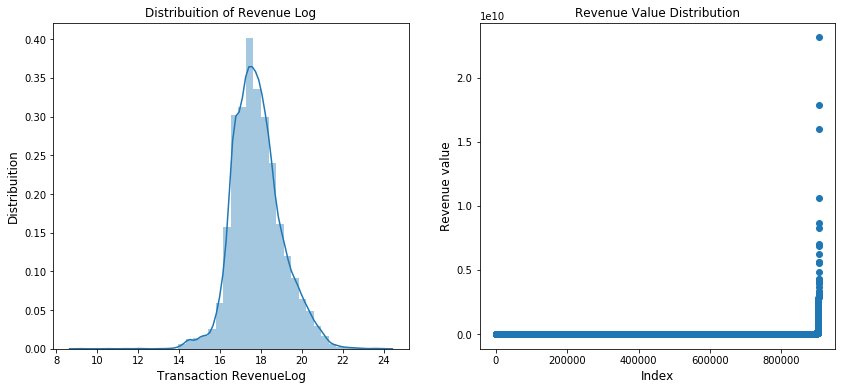

In [8]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)

ax = sns.distplot(
    np.log1p(train_df[train_df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"] + 0.01), 
    bins=40, 
    kde=True
)
ax.set_xlabel('Transaction RevenueLog', fontsize=12) 
ax.set_ylabel('Distribuition', fontsize=12) 
ax.set_title("Distribuition of Revenue Log", fontsize=12) 

plt.subplot(1,2,2)

plt.scatter(range(train_df.shape[0]), np.sort(train_df['totals.transactionRevenue'].values))
plt.xlabel('Index', fontsize=12)
plt.ylabel('Revenue value', fontsize=12) 
plt.title("Revenue Value Distribution", fontsize=12) 

plt.show()

### Crossing Channel Grouping x Browsers

In [ ]:
crosstab_eda = pd.crosstab(
    index=train_df['channelGrouping'], normalize=True,
    columns=train_df[train_df['device.browser'].isin(train_df['device.browser'].value_counts()[:5].index.values)]['device.browser']
)

crosstab_eda.plot(
    kind="bar",    
    figsize=(14,6),
    stacked=True
)

plt.title("Channel Grouping % for which Browser", fontsize=12) 
plt.xlabel("The Channel Grouping Name", fontsize=12) 
plt.ylabel("Count", fontsize=12) 
plt.xticks(rotation=0)

plt.show() 

### Crossing Operation Systems x Browsers

In [ ]:
crosstab_eda = pd.crosstab(
    index=train_df[train_df['device.operatingSystem'].isin(train_df['device.operatingSystem'].value_counts()[:6].index.values)]['device.operatingSystem'], 
    columns=train_df[train_df['device.browser'].isin(train_df['device.browser'].value_counts()[:5].index.values)]['device.browser'])

crosstab_eda.plot(
    kind="bar",    
    figsize=(14,6), 
    stacked=True
)   

plt.title("Most frequent OS's by Browsers of users", fontsize=12) 
plt.xlabel("Operational System Name", fontsize=12) 
plt.ylabel("Count OS", fontsize=12) 
plt.xticks(rotation=0) 

plt.show()

### Crossing Device Catgory x Operating Systems

In [ ]:
crosstab_eda = pd.crosstab(
    index=train_df['device.deviceCategory'], 
    columns=train_df[train_df['device.operatingSystem'].isin(train_df['device.operatingSystem'].value_counts()[:6].index.values)]['device.operatingSystem']
)

crosstab_eda.plot(
    kind="bar",    
    figsize=(14,6), 
    stacked=True
)   
plt.title("Most frequent OS's by Device Categorys of users", fontsize=12) 
plt.xlabel("Device Name", fontsize=12)                
plt.ylabel("Count Device x OS", fontsize=12)          
plt.xticks(rotation=0)                                

plt.show()

In [ ]:
number_of_colors = 20 

color = [
    "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
    for i in range(number_of_colors)
]

### Exploring Countries

In [ ]:
country_tree = train_df["geoNetwork.country"].value_counts() 

print("Description most frequent countrys: ")
print(country_tree[:15])

country_tree = round(
    (train_df["geoNetwork.country"].value_counts()[:30] / len(train_df['geoNetwork.country']) * 100),
    2
)

plt.figure(figsize=(14,6))

g = squarify.plot(
    sizes=country_tree.values, 
    label=country_tree.index, 
    value=country_tree.values,
    alpha=.4, 
    color=color
)
g.set_title("'TOP 30 Countrys - % size of total",fontsize=12)
g.set_axis_off()
plt.show()


### Exploring Cities

In [ ]:
city_tree = train_df["geoNetwork.city"].value_counts()

print("Description most frequent Citys: " )
print(city_tree[:15])

city_tree = round(
    (train_df["geoNetwork.city"].value_counts()[:30] / len(train_df['geoNetwork.city']) * 100),
    2
)

plt.figure(figsize=(14,6))

g = squarify.plot(
    sizes=city_tree.values, 
    label=city_tree.index, 
    value=city_tree.values,
    alpha=.4, 
    color=color
)

g.set_title("'TOP 30 Citys - % size of total",fontsize=12)
g.set_axis_off()
plt.show()

In [ ]:
def PieChart(df_colum, title, limit=15):
    count_trace = train_df[df_colum].value_counts()[:limit].to_frame().reset_index()
    rev_trace = train_df.groupby(df_colum)["totals.transactionRevenue"].sum().nlargest(10).to_frame().reset_index()

    trace1 = go.Pie(
        labels=count_trace['index'], 
        values=count_trace[df_colum], 
        name= "% Acesses", 
        hole= .5, 
        hoverinfo="label+percent+name", 
        showlegend=True,
        domain= {'x': [0, .48]}, 
        marker=dict(colors=color)
    )

    trace2 = go.Pie(
        labels=rev_trace[df_colum], 
        values=rev_trace['totals.transactionRevenue'], 
        name="% Revenue", 
        hole= .5, 
        hoverinfo="label+percent+name", 
        showlegend=False, 
        domain= {'x': [.52, 1]}
    )

    layout = dict(
        title= title, 
        height=450, 
        font=dict(size=15),
        annotations = [
            dict(x=.25, y=.5, text='Visits', showarrow=False, font=dict(size=20)),
            dict(x=.80, y=.5, text='Revenue', showarrow=False, font=dict(size=20))
        ]
    )

    fig = dict(data=[trace1, trace2], layout=layout)
    iplot(fig)

### Device Category feature

In [ ]:
PieChart("device.deviceCategory", "Device Category")

### Device Borwser feature

In [ ]:
PieChart("device.browser", "Device Browser")

### Operating System feature

In [ ]:
PieChart("device.operatingSystem", "Operating System")

Now let us encode the features an normilize them so that the values are between 0 and 1. I will be using LabelEncoder from sklearn to encode the values. Then use MinMaxScaler to normalize the feature values between 0 and 1.

In [9]:
%%time

str_cols = [
    'channelGrouping', 'device.browser', 'device.deviceCategory', 'device.isMobile', 
    'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 
    'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent', 
    'trafficSource.campaign', 'trafficSource.isTrueDirect', 'trafficSource.keyword', 
    'trafficSource.medium', 'trafficSource.source', 'trafficSource.referralPath'
]

num_cols = [
    'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'visitNumber', 'visitStartTime'
]

train_core_df = train_core_df = train_df.loc[:, ['fullVisitorId', 'date', 'totals.transactionRevenue']]
test_core_df = test_df.loc[:, ['fullVisitorId', 'date']]

train_rest_df = train_df.loc[:, str_cols + num_cols]
test_rest_df = test_df.loc[:, str_cols + num_cols]

print('Encoding str_cols...')

for str_col in str_cols:
    labelEncoder = LabelEncoder()
    
    train_col_list = list(train_rest_df[str_col].astype('str'))
    test_col_list = list(test_rest_df[str_col].astype('str'))
    
    labelEncoder.fit(train_col_list + test_col_list)
    
    train_rest_df[str_col] = labelEncoder.transform(train_col_list)
    test_rest_df[str_col] = labelEncoder.transform(test_col_list)

print('Encoding num_cols...')

for num_col in num_cols:
    train_rest_df[num_col] = train_rest_df[num_col].astype('float')
    test_rest_df[num_col] = test_rest_df[num_col].astype('float')
    
minMaxScaler = MinMaxScaler()

print('Min Max Scalling  train_df...')

normalized_train_df = pd.DataFrame(minMaxScaler.fit_transform(train_rest_df.astype('float')))
normalized_train_df.columns = train_rest_df.columns
normalized_train_df.index = train_rest_df.index

print('Min Max Scalling  test_df...')

normalized_test_df = pd.DataFrame(minMaxScaler.fit_transform(test_rest_df.astype('float')))
normalized_test_df.columns = test_rest_df.columns
normalized_test_df.index = test_rest_df.index
print()

CPU times: user 1min 23s, sys: 15.6 s, total: 1min 39s
Wall time: 1min 49s


In [10]:
normalized_train_df.describe()

,channelGrouping,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,...,trafficSource.keyword,trafficSource.medium,trafficSource.source,trafficSource.referralPath,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,visitNumber,visitStartTime
count,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,...,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000
mean,0.661752,0.364163,0.149185,0.264618,0.543472,0.560780,0.348330,0.717795,0.609672,0.304728,...,0.397010,0.723034,0.509666,0.839946,0.498676,0.007207,0.778020,0.006089,0.003210,0.473477
std,0.253542,0.136224,0.263029,0.441130,0.373819,0.162516,0.186848,0.305386,0.114041,0.357501,...,0.253040,0.348430,0.333683,0.304851,0.499999,0.019322,0.415578,0.015011,0.023563,0.285308
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.571429,0.284483,0.000000,0.000000,0.260870,0.579665,0.200000,0.422907,0.595041,0.007671,...,0.113337,0.800000,0.416834,0.814768,0.000000,0.000000,1.000000,0.000000,0.000000,0.238007
50%,0.571429,0.284483,0.000000,0.000000,0.869565,0.579665,0.200000,0.925110,0.595041,0.100574,...,0.617140,0.800000,0.416834,1.000000,0.000000,0.002004,1.000000,0.000000,0.000000,0.440009
75%,1.000000,0.387931,0.500000,1.000000,0.869565,0.579665,0.400000,0.960352,0.595041,0.681960,...,0.617140,1.000000,0.835671,1.000000,1.000000,0.006012,1.000000,0.006410,0.000000,0.718603
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
cleaned_train_df = pd.concat([train_core_df, normalized_train_df], axis=1)

cleaned_train_df.head()

,fullVisitorId,date,totals.transactionRevenue,channelGrouping,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,...,trafficSource.keyword,trafficSource.medium,trafficSource.source,trafficSource.referralPath,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,visitNumber,visitStartTime
0,1131660440785968503,20160902,0.0,0.571429,0.284483,0.0,0.0,0.869565,0.395178,0.4,...,0.113337,0.8,0.416834,1.0,1.0,0.0,1.0,0.0,0.000000,0.088405
1,377306020877927890,20160902,0.0,0.571429,0.353448,0.0,0.0,0.260870,0.579665,1.0,...,0.113337,0.8,0.416834,1.0,1.0,0.0,1.0,0.0,0.000000,0.089979
2,3895546263509774583,20160902,0.0,0.571429,0.284483,0.0,0.0,0.869565,0.496855,0.6,...,0.113337,0.8,0.416834,1.0,1.0,0.0,1.0,0.0,0.000000,0.089512
3,4763447161404445595,20160902,0.0,0.571429,0.672414,0.0,0.0,0.217391,0.579665,0.4,...,0.298089,0.8,0.416834,1.0,1.0,0.0,1.0,0.0,0.000000,0.090012
4,27294437909732085,20160902,0.0,0.571429,0.284483,0.5,1.0,0.000000,0.579665,0.6,...,0.113337,0.8,0.416834,1.0,1.0,0.0,0.0,0.0,0.002538,0.088159


In [12]:
cleaned_test_df = pd.concat([test_core_df, normalized_test_df], axis=1)

cleaned_test_df.head()

,fullVisitorId,date,channelGrouping,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,...,trafficSource.keyword,trafficSource.medium,trafficSource.source,trafficSource.referralPath,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,visitNumber,visitStartTime
0,6167871330617112363,20171016,0.571429,0.265625,0.0,0.0,0.260870,0.579832,0.4,0.778761,...,0.112163,0.8,0.417671,1.0,0.0,0.006012,0.0,0.006012,0.002193,0.276326
1,0643697640977915618,20171016,0.571429,0.265625,0.0,0.0,0.869565,0.994748,0.6,0.818584,...,0.112163,0.8,0.417671,1.0,0.0,0.008016,1.0,0.008016,0.000000,0.277368
2,6059383810968229466,20171016,0.571429,0.265625,0.0,0.0,0.260870,0.579832,0.6,0.300885,...,0.112163,0.8,0.417671,1.0,0.0,0.012024,1.0,0.012024,0.000000,0.275994
3,2376720078563423631,20171016,0.571429,0.562500,0.5,1.0,1.000000,0.565126,0.2,0.964602,...,0.112163,0.8,0.417671,1.0,0.0,0.014028,1.0,0.006012,0.000000,0.278134
4,2314544520795440038,20171016,0.571429,0.562500,0.0,0.0,0.260870,0.787815,0.2,0.964602,...,0.112163,0.8,0.417671,1.0,0.0,0.016032,1.0,0.006012,0.000000,0.279152


In [ ]:
print('Transactions Minimum Date: {}'.format(cleaned_train_df['date'].min()))
print('Transactions Maximum Date: {}\n'.format(cleaned_train_df['date'].max()))

Now that we have normalized the data we need to split the dataset into development, validation. I will be splitting the data into 
- dev: 85% i.e, date ranges between 20160801 - 20170531
- val: 15% i.e. date ranges between 20170601 - 20170801

In [13]:
%%time

cleaned_train_df["date"] = cleaned_train_df["date"].astype('str').apply(lambda x: parse(x, yearfirst=True))

dev_df = cleaned_train_df[cleaned_train_df['date'] < datetime(2017, 6, 1)]
val_df = cleaned_train_df[cleaned_train_df['date'] >= datetime(2017, 6, 1)]

feature_cols = ['fullVisitorId'] + str_cols + num_cols

dev_X = dev_df[['totals.transactionRevenue'] + feature_cols]
val_X = val_df[['totals.transactionRevenue'] + feature_cols]
test_X = cleaned_test_df[feature_cols]

print('\nNumber of instances in train: {} with {} columns.'.format(dev_X.shape[0], dev_X.shape[1]))
print('\nNumber of instances in val: {} with {} columns.'.format(val_X.shape[0], val_X.shape[1]))
print('\nNumber of instances in test: {} with {} columns.'.format(test_X.shape[0], test_X.shape[1]))
print()


Number of instances in train: 765707 with 26 columns.

Number of instances in val: 137946 with 26 columns.

Number of instances in test: 804684 with 25 columns.
CPU times: user 41 s, sys: 967 ms, total: 42 s
Wall time: 45.7 s


We now write these files in csv format so that we can use them in future

In [14]:
%%time

dev_X.to_csv(train_file, index=False, compression='zip')
val_X.to_csv(val_file, index=False, compression='zip')
test_X.to_csv(test_file, index=False, compression='zip')